*workpath*  --- рабочая директория

In [1]:
workpath = "C:/Users/Dmitry/Documents/SRH_shift_maps/"

#### Импорт библиотек и настройка директорий:

In [2]:
import os
from astropy.io import fits
from SRH_ShiftModule import *

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_cols
from tqdm.notebook import tqdm
import time
import shutil
#%matplotlib widget

homedatapath = workpath + 'testdata/'
outputpath = workpath+ 'output/'
#os.chdir(workpath)

##### Создаем список имен радиокарт

In [3]:
all_data_list = []
paths = os.listdir(homedatapath)
for item in paths:
    brick = os.listdir(homedatapath + item +'/')
    for piece in brick:
        all_data_list.append(srh_mapname_ANF(piece, homepath=homedatapath + item +'/'))

all_data_list

##### Сортируем список имен карт *по нужному критерию*

In [4]:
maps_list_I = []

for map_object in all_data_list:
    if map_object.observer =='SRH0612' and map_object.channel == 'CH02' and map_object.time==dt.time(8, 47):
        if map_object.plr == 'I':    maps_list_I.append(map_object)

    if map_object.observer =='SRH0612' and map_object.channel == 'CH02':
        if map_object.plr == 'I':    maps_list_I.append(map_object)


maps_list_I.sort(key= lambda map: map.time)
maps_list_I.sort(key= lambda map: map.freq)

for map in maps_list_I:
    print(map.name)

SRH0612_CH02_6.60GHz_I_20230712_084700.fits
SRH0612_CH02_6.60GHz_I_20230712_084700.fits
SRH0612_CH02_6.60GHz_I_20230712_084704.fits
SRH0612_CH02_6.60GHz_I_20230712_084707.fits
SRH0612_CH02_6.60GHz_I_20230712_084711.fits
SRH0612_CH02_6.60GHz_I_20230712_084714.fits
SRH0612_CH02_6.60GHz_I_20230712_084718.fits
SRH0612_CH02_6.60GHz_I_20230712_084721.fits
SRH0612_CH02_6.60GHz_I_20230712_084725.fits
SRH0612_CH02_6.60GHz_I_20230712_084728.fits
SRH0612_CH02_6.60GHz_I_20230712_084732.fits
SRH0612_CH02_6.60GHz_I_20230712_084735.fits
SRH0612_CH02_6.60GHz_I_20230712_084739.fits
SRH0612_CH02_6.60GHz_I_20230712_084742.fits
SRH0612_CH02_6.60GHz_I_20230712_084746.fits
SRH0612_CH02_6.60GHz_I_20230712_084749.fits
SRH0612_CH02_6.60GHz_I_20230712_084753.fits
SRH0612_CH02_6.60GHz_I_20230712_084756.fits
SRH0612_CH02_6.60GHz_I_20230712_084800.fits
SRH0612_CH02_6.60GHz_I_20230712_084804.fits
SRH0612_CH02_6.60GHz_I_20230712_084807.fits
SRH0612_CH02_6.60GHz_I_20230712_084811.fits
SRH0612_CH02_6.60GHz_I_20230712_

##### Для одной частоты по временному промежутку.

В функции *contr_AR* необходимо ввести границы стационарной области, по которой будем двигать все карты.

In [5]:
def contr_AR(map):
    """ Выделение стационарной области, видимой в радио"""
    return map[130:220,200:280]


In [6]:
start = time.time()

with fits.open(maps_list_I[0].homepath) as hdul0:
    backgrnd_I = hdul0[0].data

In_list = []
headers_list = []

for item in tqdm(maps_list_I):
    with fits.open(item.homepath) as hdul:
        map = hdul[0].data
        headers_list.append(hdul[0].header)

    best_delta1, minimum1 = find_min_deviation(contr_AR(backgrnd_I), contr_AR(map), delta_shift = [2, 2])
    map = shift(map, best_delta1)
    In_list.append(map)


finish = time.time()
res = finish - start
print(f'Время выполнения кода: {round(res, 2)} секунд')

  0%|          | 0/107 [00:00<?, ?it/s]

Время выполнения кода: 19.64 секунд


Посмотрим на результат наложения после сдвига:

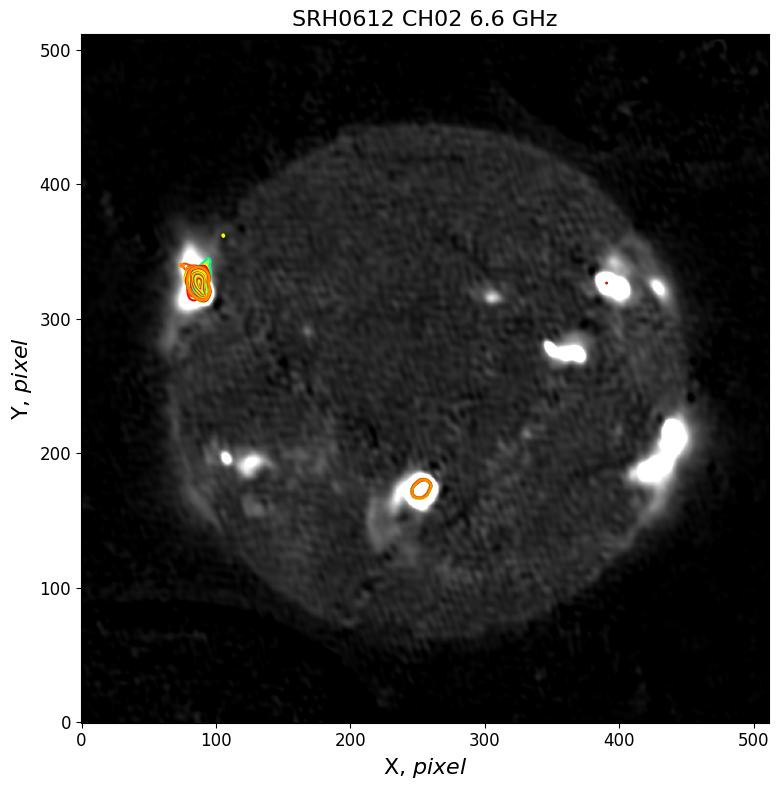

In [7]:
cols = makecolors()
size_of_words = 16

fig = plt.figure(figsize=(8, 8))
plt.imshow(backgrnd_I, origin = 'lower', cmap = 'gray', norm = mpl_cols.Normalize(vmin = 500, vmax = 9e4))#, norm = mpl_cols.Normalize(vmin = -9e5, vmax = 4e6))

for i in range(0,len(In_list)-20):
    plt.contour(In_list[i], levels = [np.max(backgrnd_I)*0.4], origin='lower', colors =cols[i])
plt.xlabel('X, $pixel$', fontsize=size_of_words)
plt.ylabel('Y, $pixel$', fontsize=size_of_words)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(maps_list_I[1].observer+' ' + maps_list_I[1].channel+' ' + str(maps_list_I[1].freq)+' GHz', fontsize=size_of_words)
plt.tight_layout()
plt.show()

Сохраняем

In [8]:
try:
    os.mkdir(outputpath)
except FileNotFoundError:
    os.makedirs(os.path.dirname(outputpath), exist_ok=True)
    os.mkdir(outputpath)
except FileExistsError:
    shutil.rmtree(outputpath)
    os.mkdir(outputpath)

for i in range(1, len(In_list)):
    hdu_I = fits.PrimaryHDU(data=In_list[i], header=headers_list[i])
    hdu_I.writeto(outputpath + maps_list_I[i].name)


Очистка кеш-памяти от построения картинок, если делали их много:

In [9]:
import gc

def MatplotlibClearMemory():
    allfignums = plt.get_fignums()
    for i in allfignums:
        fig = plt.figure(i)
        fig.clear()
        plt.close(fig)
        
MatplotlibClearMemory()
plt.figure().clear()
plt.close()
gc.collect()

718